# Parish Departures and infection



Many  people who  participated in round 1 of the serology tests did not  show up  for round 2.
This is much more  the case  for temp workers vs non-temp workers.
Temp workers also had  much higher infection rates than non-temp  workers.

Did people leave the country after  round 1 of tests? 

We can explore  this by combining  insights from the mobility data and serology data:

By using inferred  home parishes from mobility  data, and seeing when people left the country, by parish, and matching  this up with the rate  of people who did test 1, but  not test 2, by Parish.

#### This is a summary

This pulls from work done in 
- (panel data tests) https://github.com/CityScope/CSL_Andorra_COVID/blob/master/python/home_inference_data_panel_tests.ipynb
- (parish departures and test participation) https://github.com/CityScope/CSL_Andorra_COVID/blob/master/python/parish_departures_and_infection.ipynb

In [3]:
%config IPCompleter.greedy=True # jupyter autocomplete
%config InlineBackend.figure_format = 'retina'

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from scipy.stats import pearsonr

In [4]:
IMSI = 'imsi'
MCC = 'mcc'
PARISH = 'parish'
DAYS = 'days'
NIGHTS = 'nights'

DATA_FILEPATH = '../data/private/'

def get_homes_filepath(year, month):
    return '{}homes/{}_{}_homes.csv'.format(DATA_FILEPATH, year, month)

def get_stays_filepath(year, month, day):
    return '{}stays/{}_{}/stays_{}_{}_{}.csv'.format(DATA_FILEPATH, year, month, year, month, day)

load in homes and presence data used below

In [7]:
may_2020_homes_df = pd.read_csv(get_homes_filepath(2020, 5))
may_2019_homes_df = pd.read_csv(get_homes_filepath(2019, 5))

In [16]:
may_2020_homes_df.drop(IMSI, axis=1).head(3)

,parish,days,nights,mcc,datafiles
0,Andorra la Vella,31,10,213,31
1,Andorra la Vella,7,5,214,31
2,Andorra la Vella,9,1,213,31


## Comparing RNC population to known population

To evaluate the inferences of home parishes, this data is compared to official population statistics from 2020.
https://www.estadistica.ad/serveiestudis/noticies/noticia5059cat.pdf

This evaluation uses data from May, 2020 and is restricted to the subscribers that the pre-processing categorizes as non-tourists (i.e. present for at least 50 days in Andorra), and further restricts this set of subscribers using Andorra as their home network. The month of May is used because it was the last month of the lockdown before the country reopened its borders. Furthermore, it was the month during which the serology tests were done.

The pearson correlation between the parish-level populations inferred from this analysis and  the official population statistics is 0.959.

### Presence and home inference

In [29]:
ANDORRAN_SIM = 'Andorran SIM'
MCC_ANDORRA = 213
mcc_names_dict = {
    213:'Andorran',
    214:'Spanish',
    208:'French',
    234:'British',
}
for df in [may_2019_homes_df, may_2020_homes_df]:
    df[ANDORRAN_SIM] = (df[MCC]==MCC_ANDORRA)

In [30]:
# don't show IMSI
may_2019_homes_df.drop(IMSI, axis=1).head()
may_2020_homes_df.drop(IMSI, axis=1).head()

,parish,days,nights,mcc,datafiles,Andorran SIM
0,Andorra la Vella,31,10,213,31,True
1,Andorra la Vella,7,5,214,31,False
2,Andorra la Vella,9,1,213,31,True
3,Sant Julià de Lòria,2,2,208,31,False
4,Andorra la Vella,3,2,214,31,False


Make a dataframe from the May 2020 homes data restricted to the non-tourists with columns:
```
imsi, parish, days, Andorran SIM
```

non-tourists were classified as the users with more than 50 days of data reported January - October.

In [8]:
PRESENCE_OTHERS_FILEPATH = DATA_FILEPATH+'days_present/presence_others.csv'

In [32]:
may_2020_users_count = may_2020_homes_df[IMSI].nunique()
print('%s May 2020 users' % may_2020_users_count)
# Get the list of users who were considered non-tourists
o_presence_imsis = pd.read_csv(PRESENCE_OTHERS_FILEPATH).rename(columns={'Unnamed: 0': IMSI})[IMSI]
# Restrict the May 2020 data to others presence data imsis
o_may_2020_homes_df = may_2020_homes_df[may_2020_homes_df[IMSI].isin(o_presence_imsis)][[
    IMSI, PARISH, DAYS, ANDORRAN_SIM,
]]
o_may_2020_users_count = len(o_may_2020_homes_df)
print('%s May 2020 \'non-tourist\' users' % o_may_2020_users_count)
# Restrict to Andorran SIMs
o_a_may_2020_homes_df = o_may_2020_homes_df[o_may_2020_homes_df[ANDORRAN_SIM]==True].drop(columns=[ANDORRAN_SIM])
o_a_may_2020_users_count = len(o_a_may_2020_homes_df)
print('%s May 2020 \'non-tourist\' users with Andorran SIMs' % o_a_may_2020_users_count)
o_a_may_2020_homes_df.drop(IMSI, axis=1).head()

54309 May 2020 users
51451 May 2020 'non-tourist' users
44985 May 2020 'non-tourist' users with Andorran SIMs


,parish,days
0,Andorra la Vella,31
2,Andorra la Vella,9
5,Andorra la Vella,31
6,Andorra la Vella,27
8,Escaldes-Engordany,30


Compare inferred population with official stats

In [33]:
pop_stats_df = pd.DataFrame(data={
    PARISH: [
        'Andorra la Vella',
        'Escaldes-Engordany',
        'La Massana',
        'Ordino',
        'Sant Julià de Lòria',
        'Canillo',
        'Encamp'],
    'population': [
        22504,
        14626,
        10199,
        4957,
        9374,
        4371,
        11716]
}).set_index(PARISH)
o_a_may_2020_home_parish_counts = o_a_may_2020_homes_df[PARISH].value_counts()
pop_stats_df['inferred subscriber population'] = pop_stats_df.index.map(o_a_may_2020_home_parish_counts)
pop_stats_df = pop_stats_df.sort_index()
pop_stats_df

,population,inferred subscriber population
parish,,
Andorra la Vella,22504,13555
Canillo,4371,4367
Encamp,11716,6766
Escaldes-Engordany,14626,7366
La Massana,10199,6165
Ordino,4957,2427
Sant Julià de Lòria,9374,4339


Measure and plot correlation between populations

In [35]:
(r, p_val) = pearsonr(pop_stats_df['population'],
                      pop_stats_df['inferred subscriber population'])
r, p_val

(0.958878968948699, 0.0006441380716552824)

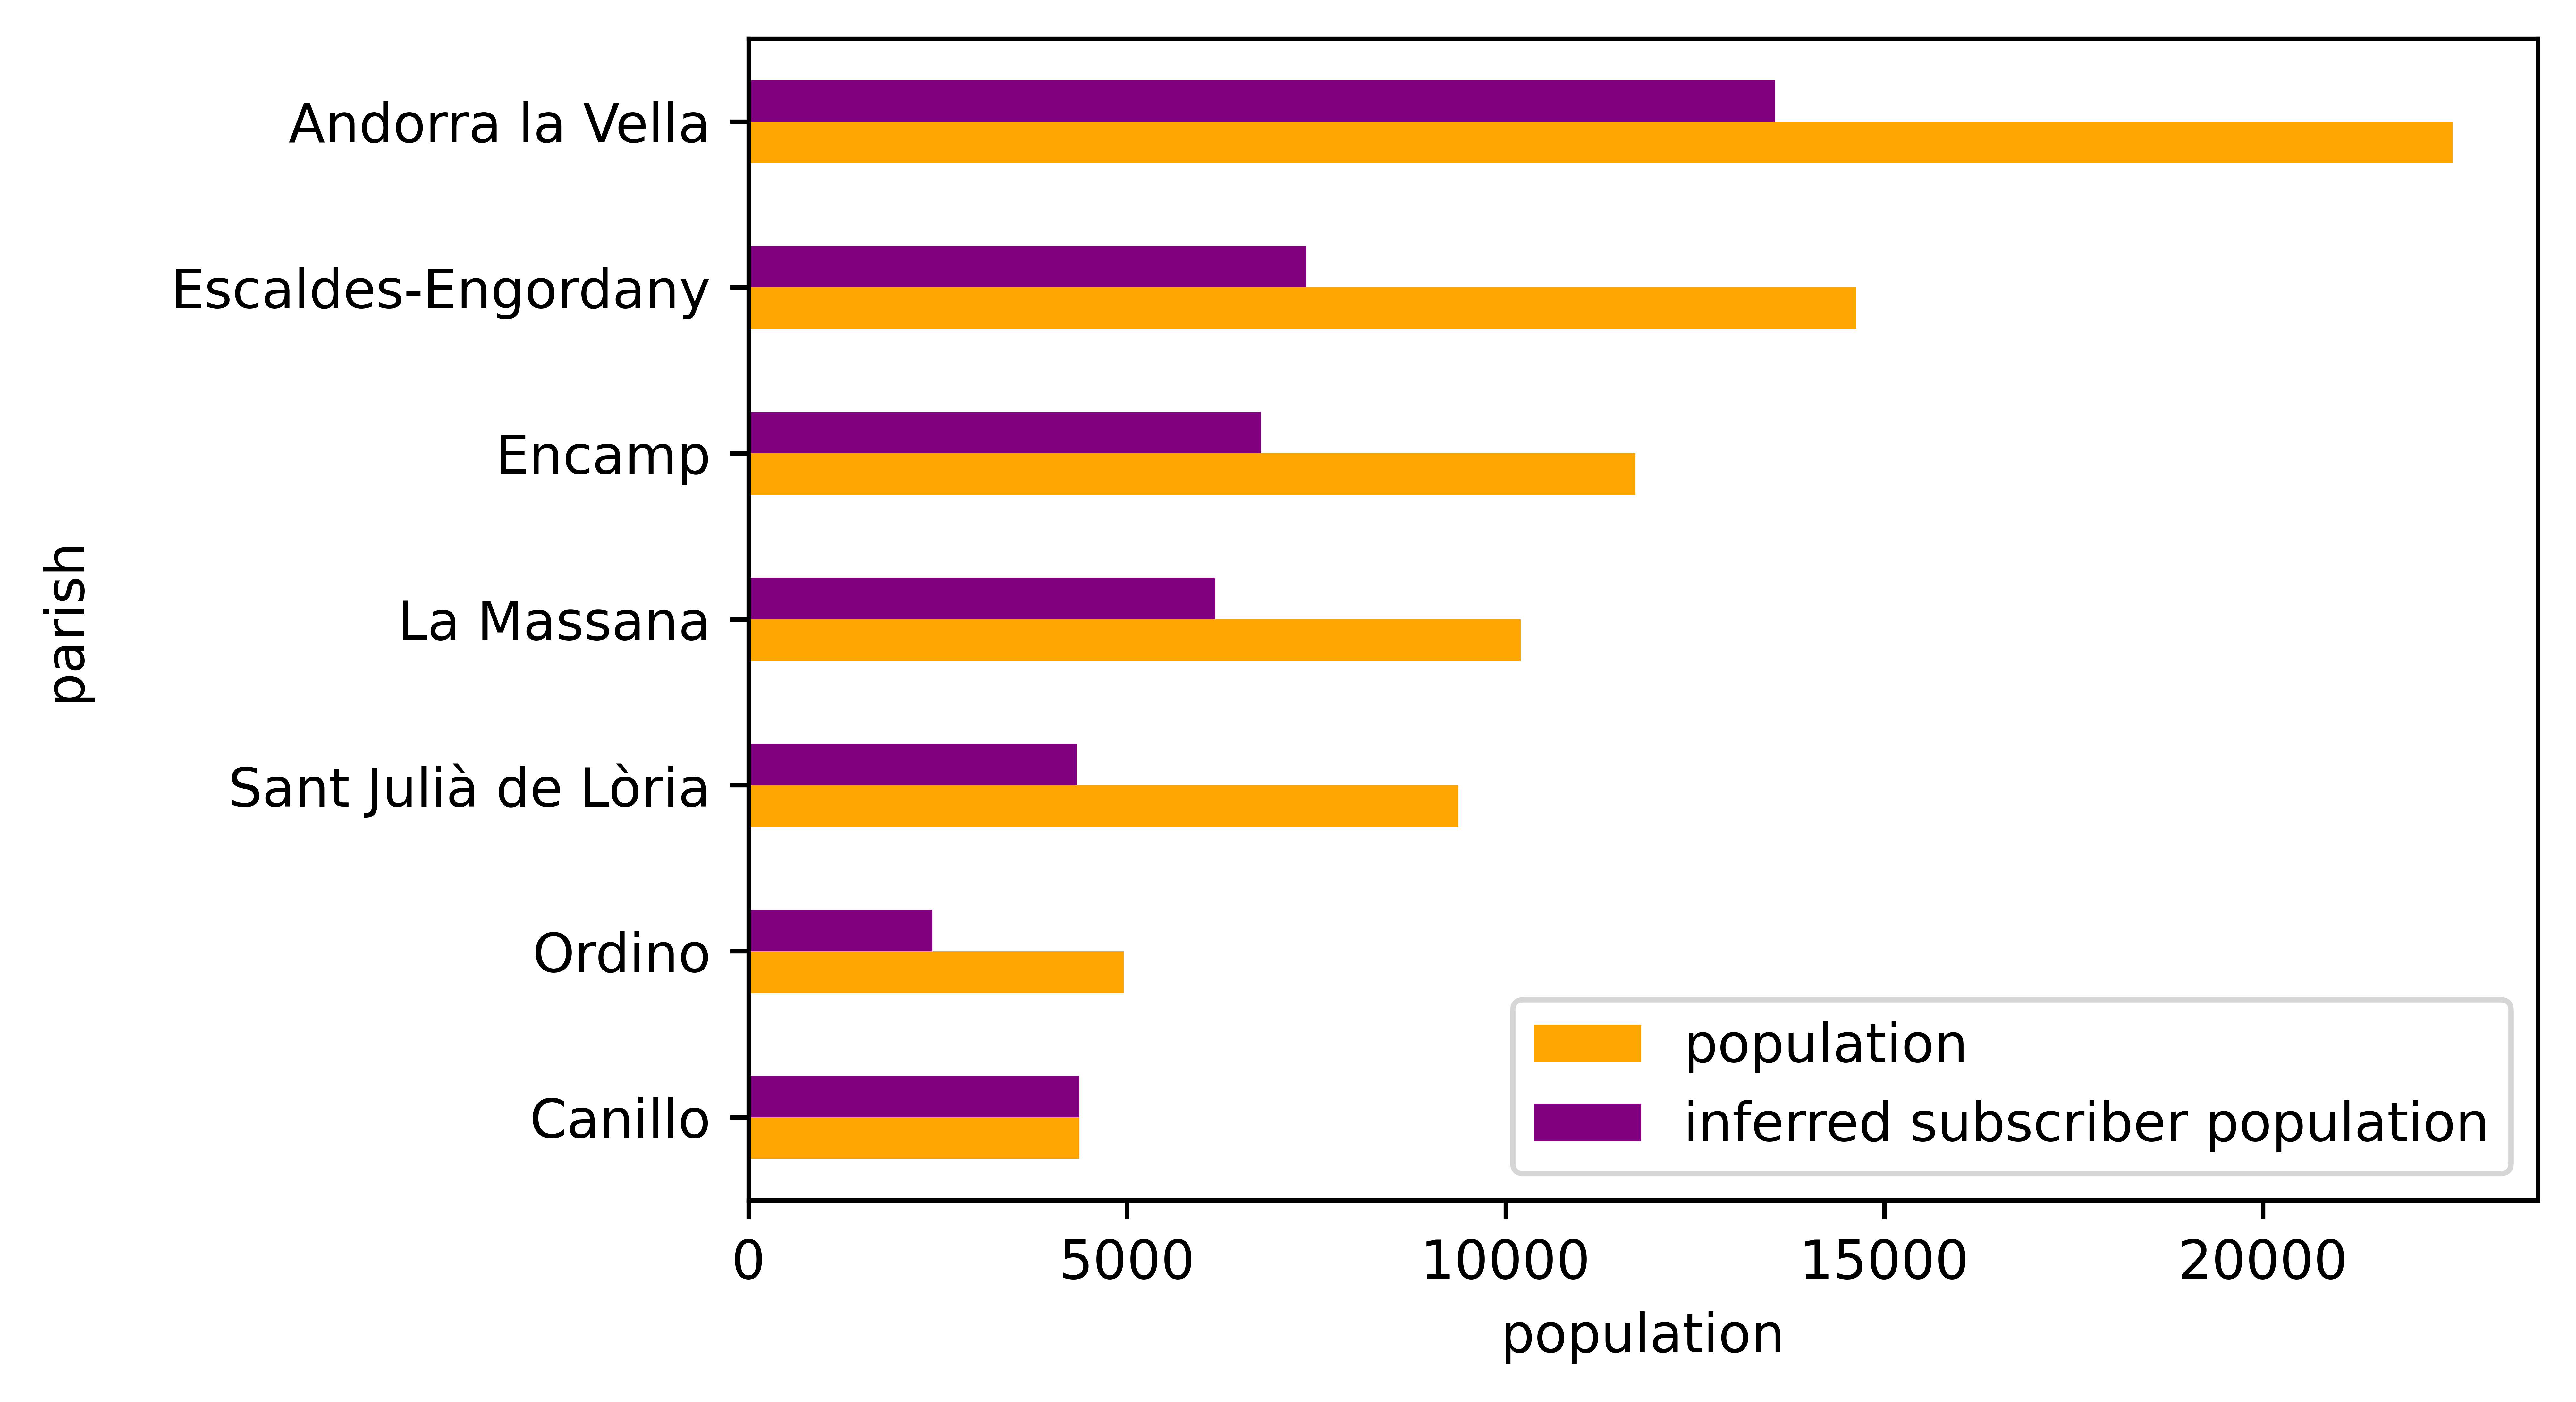

In [185]:
plt.rcParams["figure.dpi"] = 600
pop_stats_df.sort_values('population').plot.barh(color={
    'population':'orange',
    'inferred subscriber population':'purple'
})
plt.xlabel('population')
plt.ylabel('parish', labelpad=15)
plt.show()

## Parish departures and missed tests

### Serology data

In [19]:
SEROLOGY_DATA_FILEPATH = DATA_FILEPATH + 'serology_clean.csv'

In [21]:
# columns of interest

PARISH = 'parish'
DATA_TEST_1_DATE = 'data_test_1'
DATA_TEST_2_DATE = 'data_test_2'
IGM_1 = 'igm_1'
IGG_1 = 'igg_1'

POSITIVE_TEST_RESULT_VALUE = 'positiu' # positive test result  value in the original data

POSITIVE_TEST_1 = 'positive test 1'

In [53]:
# the PII is 'cens_hashed' -- ignore it / don't even need it
serology_df=pd.read_csv(SEROLOGY_DATA_FILEPATH)[
    [PARISH, DATA_TEST_1_DATE, DATA_TEST_2_DATE, IGM_1, IGG_1]]
serology_df.head()

/Users/aberke/projects/CSL_Andorra_COVID/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (9,10,14,20,24,32,33,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,parish,data_test_1,data_test_2,igm_1,igg_1
0,Escaldes Engordany,9/5/20 11:04,23/5/20 11:03,negatiu,negatiu
1,Escaldes Engordany,8/5/20 12:30,22/5/20 12:16,negatiu,negatiu
2,Andorra La Vella,6/5/20 8:29,14/5/20 9:38,negatiu,negatiu
3,La Massana,7/5/20 9:56,21/5/20 9:49,negatiu,negatiu
4,Escaldes Engordany,9/5/20 7:55,23/5/20 6:42,negatiu,negatiu


In [54]:
n_na_parish = len(serology_df[serology_df[PARISH].isna()])
print('%s people with null parish value. They will not be counted.' % n_na_parish)
parish_nulls  = serology_df[serology_df[PARISH].isna()]
print("A bunch of others have null rows too. They got into the database and didn't test. They will not be counted either.")
parish_nulls.head()

172 people with null parish value. They will not be counted.
A bunch of others have null rows too. They got into the database and didn't test. They will not be counted either.


,parish,data_test_1,data_test_2,igm_1,igg_1
411,NaN,NaN,NaN,NaN,NaN
2369,NaN,NaN,NaN,NaN,NaN
3851,NaN,NaN,NaN,NaN,NaN
5989,NaN,NaN,NaN,NaN,NaN
6800,NaN,NaN,NaN,NaN,NaN


### How does the rate at which people left parishes compare to rate at which people skipped the 2nd test?

In [56]:
N = 'N'
N_TEMPS = 'N temps'
DID_TEST_1_NOT_2  = 'did test 1 not 2'
N_DID_TEST_1_NOT_2  = N+' '+DID_TEST_1_NOT_2
P_DID_TEST_1_NOT_2  = 'portion '+DID_TEST_1_NOT_2

serology_df[DID_TEST_1_NOT_2] = (serology_df[DATA_TEST_1_DATE].notnull() \
                                 & serology_df[DATA_TEST_2_DATE].isnull())
serology_df[[PARISH, DID_TEST_1_NOT_2]].head()

,parish,did test 1 not 2
0,Escaldes Engordany,False
1,Escaldes Engordany,False
2,Andorra La Vella,False
3,La Massana,False
4,Escaldes Engordany,False


Make a table:

```
parish, N, N did test 1 not 2, portion did test 1 not 2
```

In [60]:
parish_counts_df = serology_df[PARISH].value_counts().rename(N).to_frame().reset_index().rename(
    columns={'index':PARISH}).set_index(PARISH)
print('%s total N' % parish_counts_df[N].sum())
parish_counts_df[N_DID_TEST_1_NOT_2] = serology_df[serology_df[DID_TEST_1_NOT_2]][PARISH].value_counts()
parish_counts_df[P_DID_TEST_1_NOT_2] = parish_counts_df[N_DID_TEST_1_NOT_2]/parish_counts_df[N]
parish_counts_df

73093 total N


,N,N did test 1 not 2,portion did test 1 not 2
parish,,,
Escaldes Engordany,29348,1236,0.042115
Encamp,11254,573,0.050915
La Massana,9265,392,0.042310
Sant Julia,8892,337,0.037899
Andorra La Vella,5187,280,0.053981
Canillo,4802,478,0.099542
Ordino,4345,165,0.037975


### Using Mobility data

The serology tests were conducted  in May. The first round of tests  were  mainly  the first 2 weeks of May. The  second round of tests  were mainly the last 2 weeks of May.

For each parish, how many people who were present in the 1st week of May (May 1  - May 7) were also present in the 4th week of May (May 22 - May 28)?

How does this  change compare to the previous year?


Make a table about parish presence (for 2020 and 2019)
```
parish, N May start, N May end, portion decline
```

In [61]:
"""
Get the homes  parish data for May.

Check for user presence in May 1-7 vs May 22-28
"""

MAY_START = 'May start'
N_MAY_START = 'N '+MAY_START
MAY_END = 'May end'
N_MAY_END = 'N '+MAY_END

P_DECLINE  = 'portion decline'

In [63]:
def daterange(start_datetime, end_datetime):
    for n in range(int((end_datetime - start_datetime).days) + 1):
        yield start_datetime + timedelta(n)

date_fmt = '%Y-%m-%d'

maystart2020_dates = [d for d in daterange(datetime.strptime('2020-05-01', date_fmt), 
                                   datetime.strptime('2020-05-07', date_fmt))]
maystart2019_dates = [d for d in daterange(datetime.strptime('2019-05-01', date_fmt), 
                                   datetime.strptime('2019-05-07', date_fmt))]

mayend2020_dates = [d for d in daterange(datetime.strptime('2020-05-22', date_fmt), 
                                   datetime.strptime('2020-05-28', date_fmt))]
mayend2019_dates = [d for d in daterange(datetime.strptime('2019-05-22', date_fmt), 
                                   datetime.strptime('2019-05-28', date_fmt))]

In [64]:
def get_imsis_presence_dict(imsis, dates):
    imsis_presence_dict  = {imsi:False for imsi in imsis}
    for i, d in enumerate(dates):
        date_str = d.strftime(date_fmt)
        print('%s/%s: processing %s' % (i+1, len(dates), date_str))
        stays_df = pd.read_csv(get_stays_filepath(d.year, d.month, d.day))
        for imsi in stays_df[IMSI].unique():
            imsis_presence_dict[imsi] = True
    
    return imsis_presence_dict

In [69]:
# make a dict from stays files for dates of interest
may2020_imsis = may_2020_homes_df[IMSI].values
maystart2020_imsis_presence_dict = get_imsis_presence_dict(may2020_imsis, maystart2020_dates)
mayend2020_imsis_presence_dict = get_imsis_presence_dict(may2020_imsis, mayend2020_dates)

1/7: processing 2020-05-01
2/7: processing 2020-05-02
3/7: processing 2020-05-03
4/7: processing 2020-05-04
5/7: processing 2020-05-05
6/7: processing 2020-05-06
7/7: processing 2020-05-07
1/7: processing 2020-05-22
2/7: processing 2020-05-23
3/7: processing 2020-05-24
4/7: processing 2020-05-25
5/7: processing 2020-05-26
6/7: processing 2020-05-27
7/7: processing 2020-05-28


In [70]:
may2019_imsis = may_2019_homes_df[IMSI].values
maystart2019_imsis_presence_dict = get_imsis_presence_dict(may2019_imsis, maystart2019_dates)
mayend2019_imsis_presence_dict = get_imsis_presence_dict(may2019_imsis, mayend2019_dates)

1/7: processing 2019-05-01
2/7: processing 2019-05-02
3/7: processing 2019-05-03
4/7: processing 2019-05-04
5/7: processing 2019-05-05
6/7: processing 2019-05-06
7/7: processing 2019-05-07
1/7: processing 2019-05-22
2/7: processing 2019-05-23
3/7: processing 2019-05-24
4/7: processing 2019-05-25
5/7: processing 2019-05-26
6/7: processing 2019-05-27
7/7: processing 2019-05-28


In [73]:
may_2020_homes_df[MAY_START] = may_2020_homes_df[IMSI].map(maystart2020_imsis_presence_dict)
may_2020_homes_df[MAY_END] = may_2020_homes_df[IMSI].map(mayend2020_imsis_presence_dict)

may_2019_homes_df[MAY_START] = may_2019_homes_df[IMSI].map(maystart2019_imsis_presence_dict)
may_2019_homes_df[MAY_END] = may_2019_homes_df[IMSI].map(mayend2019_imsis_presence_dict)

may_2020_homes_df.drop(IMSI, axis=1).head() # do not show IMSI

,parish,days,nights,mcc,datafiles,Andorran SIM,May start,May end
0,Andorra la Vella,31,10,213,31,True,True,True
1,Andorra la Vella,7,5,214,31,False,False,True
2,Andorra la Vella,9,1,213,31,True,True,True
3,Sant Julià de Lòria,2,2,208,31,False,False,False
4,Andorra la Vella,3,2,214,31,False,False,True


In [74]:
print('%s total users present in May 2020'%len(may_2020_homes_df))
print('%s users present in 1st week of May 2020'%len(may_2020_homes_df[may_2020_homes_df[MAY_START]]))

print('\n%s total users present in May 2019'%len(may_2019_homes_df))
print('%s users present in 1st week of May 2019'%len(may_2019_homes_df[may_2019_homes_df[MAY_START]]))

may_2020_homes_df[may_2020_homes_df[MAY_START]].drop(IMSI, axis=1).head()

54309 total users present in May 2020
51125 users present in 1st week of May 2020

114796 total users present in May 2019
78317 users present in 1st week of May 2019


,parish,days,nights,mcc,datafiles,Andorran SIM,May start,May end
0,Andorra la Vella,31,10,213,31,True,True,True
2,Andorra la Vella,9,1,213,31,True,True,True
5,Andorra la Vella,31,16,213,31,True,True,True
6,Andorra la Vella,27,5,213,31,True,True,True
7,La Massana,28,13,204,31,False,True,True


In [76]:
# restrict the data to only users present in 1st week of May and count
def get_counts_df(df, condition_days=0, condition_nights=0):
    condition = (df[MAY_START]&(df[DAYS]>=condition_days)&(df[NIGHTS]>=condition_nights))
    counts_df = df[condition][[PARISH,MAY_START,MAY_END]].groupby(PARISH).sum()
    counts_df[P_DECLINE] = (counts_df[MAY_START]-counts_df[MAY_END])/counts_df[MAY_START]
    return counts_df

In [84]:
may_2020_counts_df = get_counts_df(may_2020_homes_df)
may_2020_counts_df['2020 population'] = may_2020_counts_df.index.map(pop_stats_df['population'])
may_2019_counts_df = get_counts_df(may_2019_homes_df)
may_2020_counts_df.sort_values(P_DECLINE)

,May start,May end,portion decline,2020 population
parish,,,,
Escaldes-Engordany,8147,7901,0.030195,14626
Sant Julià de Lòria,4890,4713,0.036196,9374
Ordino,2758,2657,0.036621,4957
Andorra la Vella,15394,14801,0.038522,22504
La Massana,7190,6894,0.041168,10199
Encamp,7464,7149,0.042203,11716
Canillo,5282,4652,0.119273,4371


In [78]:
may_2019_counts_df.sort_values(P_DECLINE)

,May start,May end,portion decline
parish,,,
Encamp,8511,7440,0.125837
Sant Julià de Lòria,9770,8289,0.151586
Ordino,3684,2978,0.191640
La Massana,10621,8428,0.206478
Andorra la Vella,29773,23389,0.214422
Canillo,5766,4029,0.301249
Escaldes-Engordany,10192,7013,0.311911


To what extent does this differ if we restrict the data to users with at least D=7 days of data?
Or N=4 nights of  data?



In [79]:
# for robustness checks:
# restrict the counts to users with at least a certain amount of days/nights of data
may_2020_7days_counts_df = get_counts_df(may_2020_homes_df, condition_days=7)
may_2019_7days_counts_df = get_counts_df(may_2019_homes_df, condition_days=7)

may_2020_4nights_counts_df = get_counts_df(may_2020_homes_df, condition_nights=4)
may_2019_4nights_counts_df = get_counts_df(may_2019_homes_df, condition_nights=4)

may_2020_7days_counts_df.sort_values(P_DECLINE)

,May start,May end,portion decline
parish,,,
Escaldes-Engordany,7992,7841,0.018894
Andorra la Vella,14947,14634,0.020941
Sant Julià de Lòria,4750,4647,0.021684
Ordino,2711,2643,0.025083
La Massana,7032,6832,0.028441
Encamp,7329,7092,0.032337
Canillo,5063,4597,0.092040


In [240]:
color_2019 = 'tab:orange'
color_2020 = 'tab:blue'

In [243]:
def plot_portion_decline(df2019, df2020, title=''):
    decline_df = pd.DataFrame({
        'population': pop_stats_df.sort_index()['population'],
        '2019': 100 * df2019.sort_index()['portion decline'],
        '2020': 100 * df2020.sort_index()['portion decline'],
    })
    plt.rcParams["figure.dpi"] = 600
    ax = decline_df.sort_values('population')[
        ['2019', '2020']
    ].plot.barh(color={'2019':color_2019, '2020':color_2020})
    ax.set_title(title)
    ax.legend()
    ax.set_xlabel('(%) Percent of week 1 subscribers who left by week 4')
    plt.ylabel('parish', labelpad=15)
    plt.show()
    return ax, decline_df

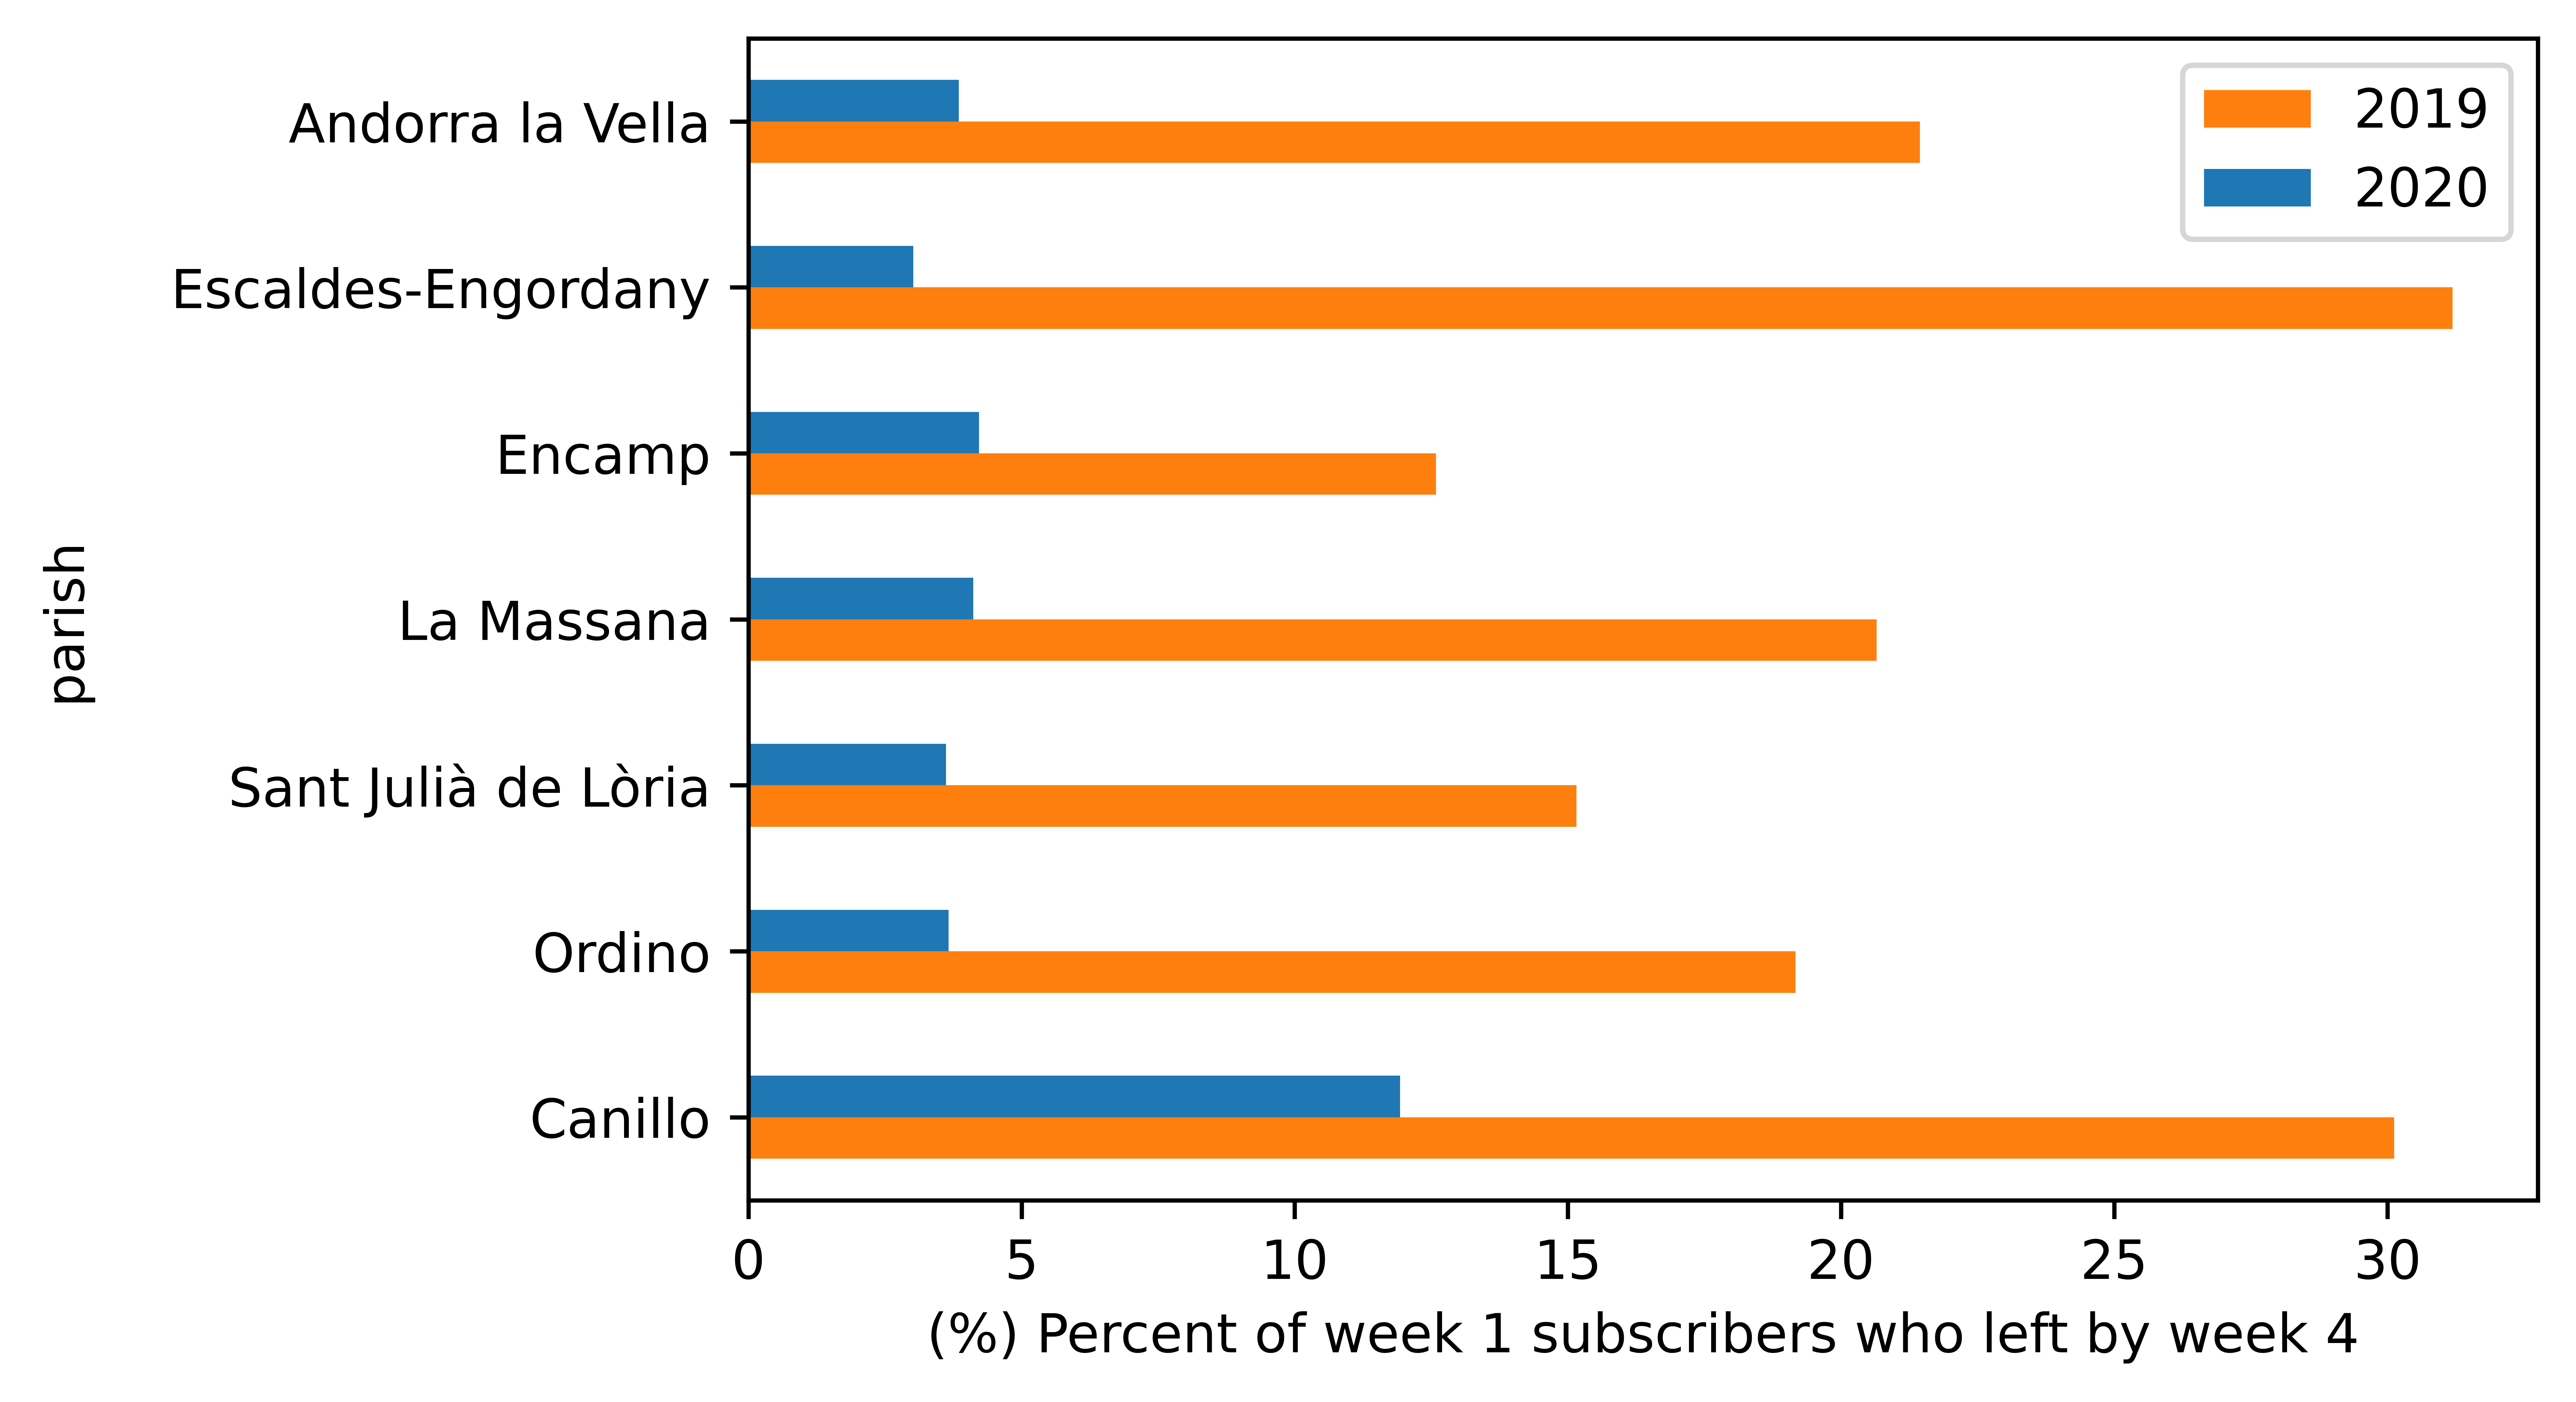

,population,2019,2020
parish,,,
Andorra la Vella,22504,21.442246,3.852150
Canillo,4371,30.124870,11.927300
Encamp,11716,12.583715,4.220257
Escaldes-Engordany,14626,31.191130,3.019516
La Massana,10199,20.647773,4.116829
Ordino,4957,19.163952,3.662074
Sant Julià de Lòria,9374,15.158649,3.619632


In [244]:
title = 'Subscribers who left between 1st and 4th weeks of May'
ax, decline_df = plot_portion_decline(may_2019_counts_df, may_2020_counts_df)#, title)
decline_df

For robustness checks: See how this compares to when restricting to users with extra data.

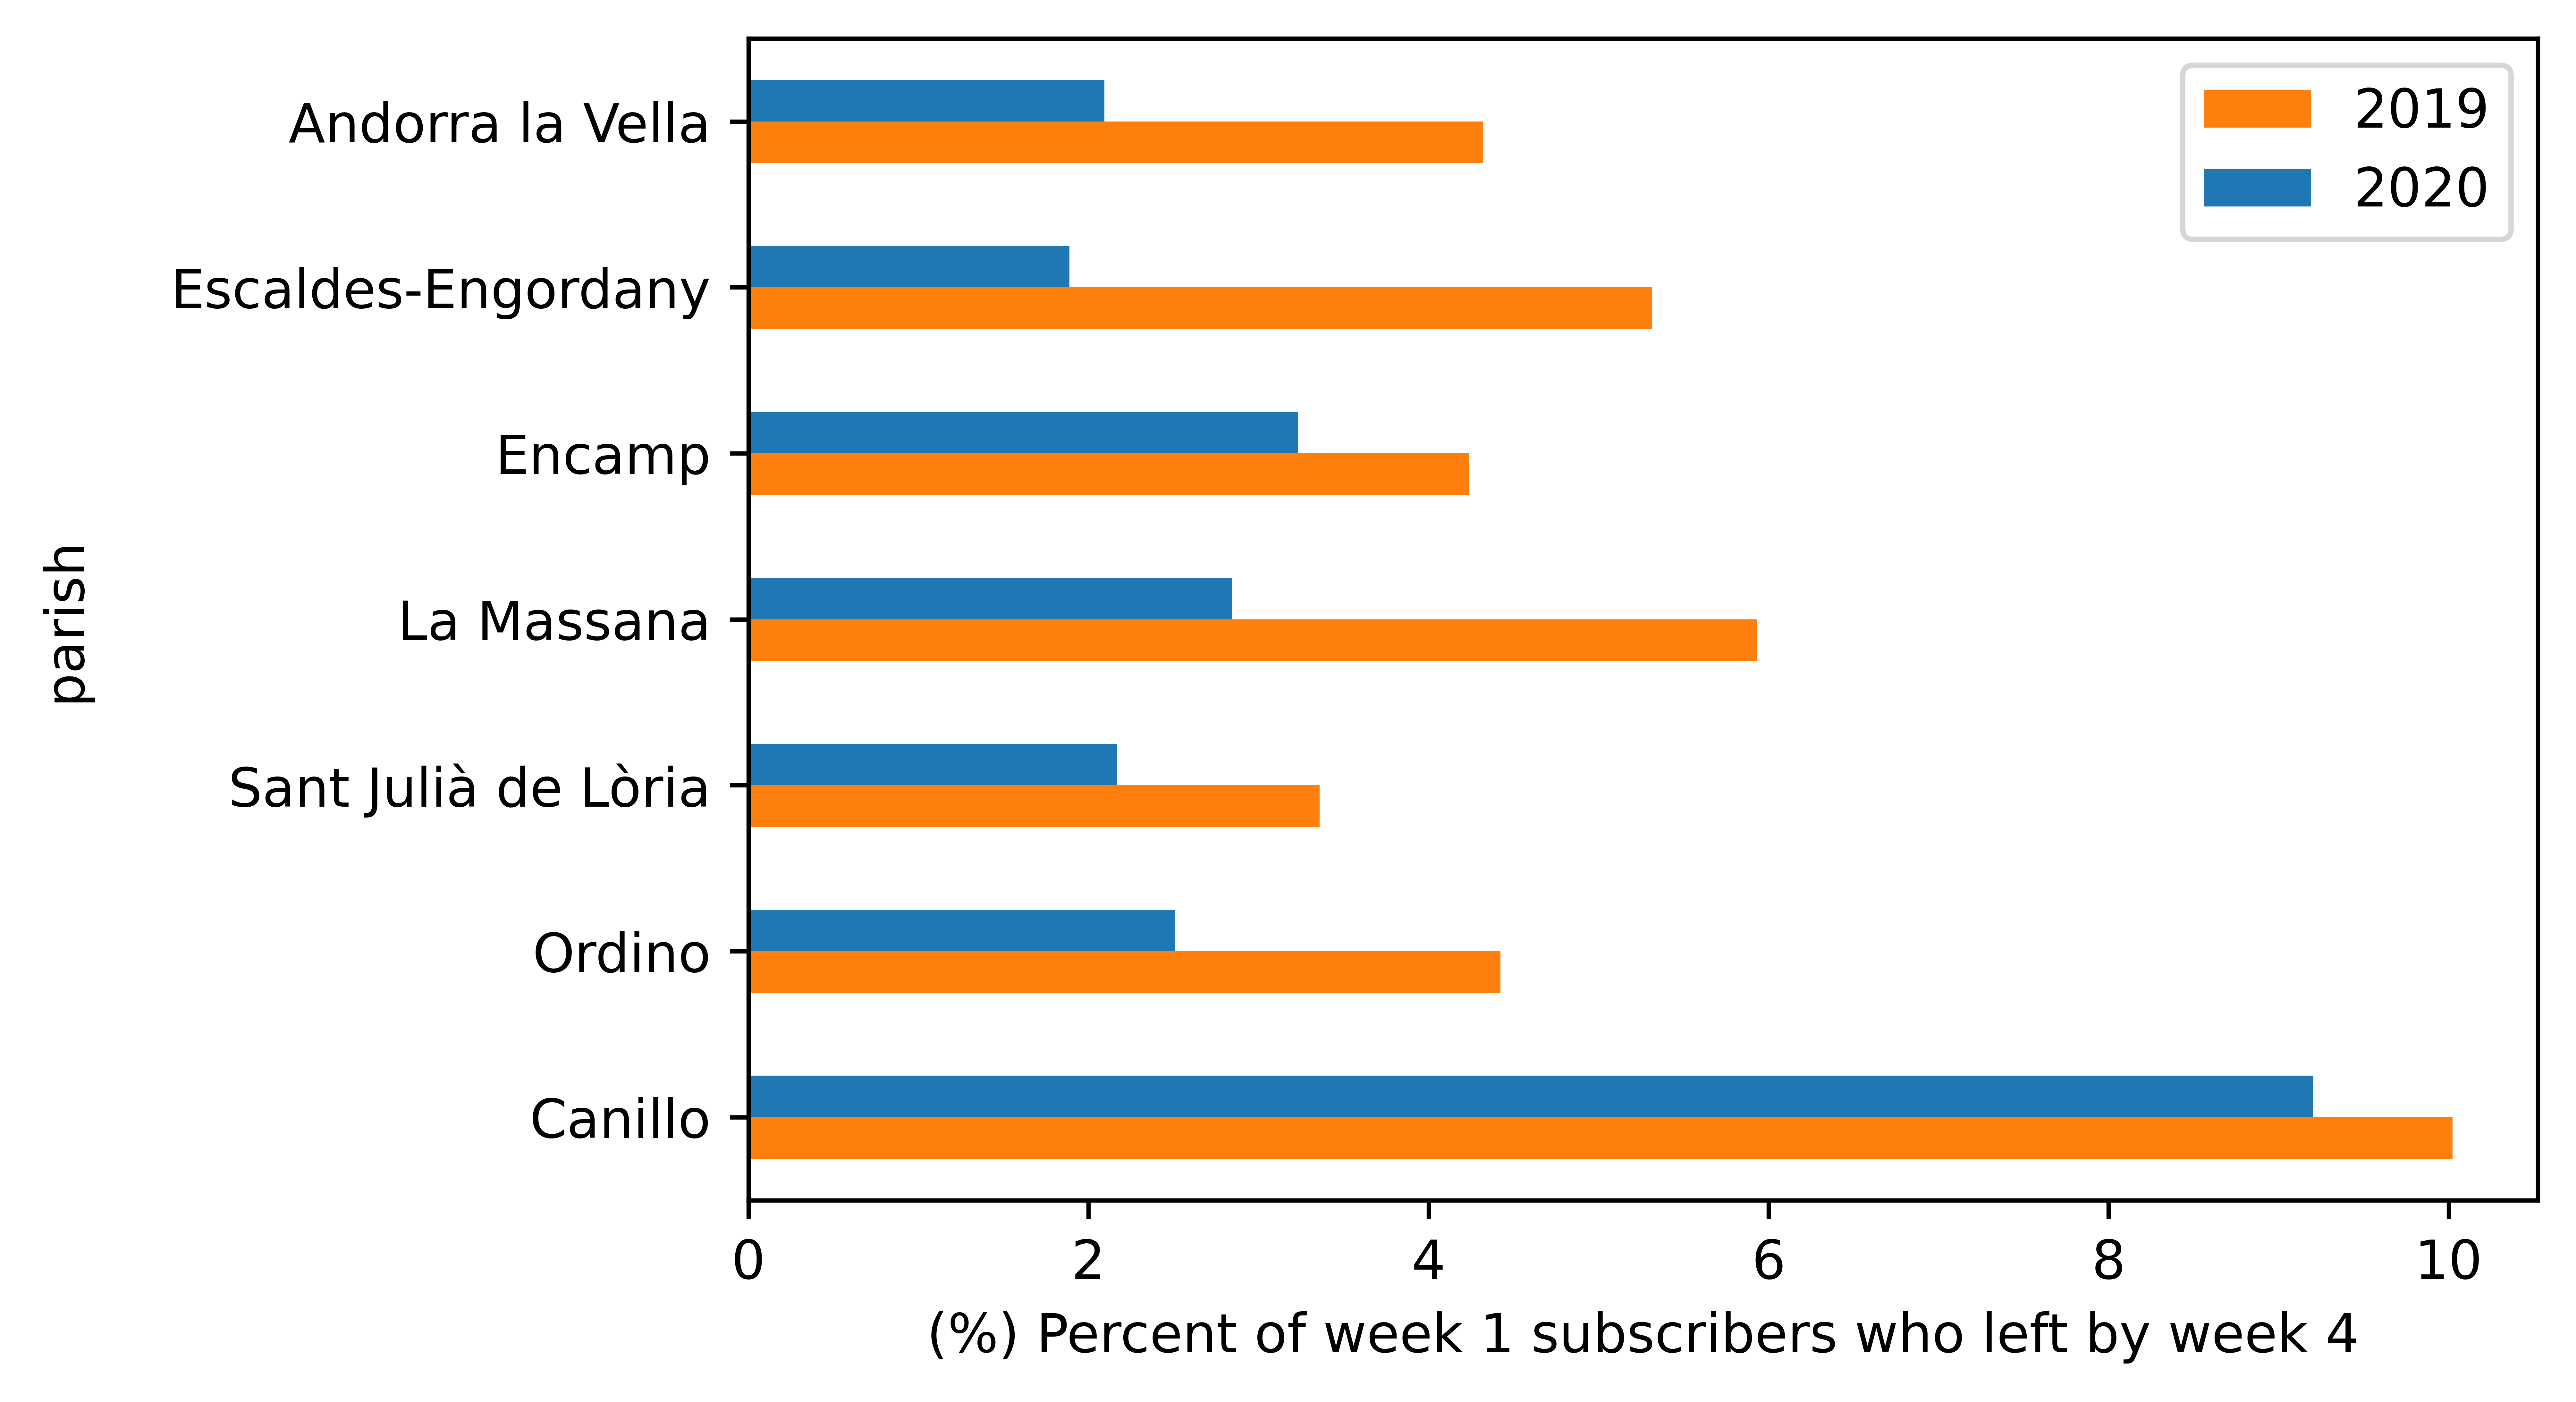

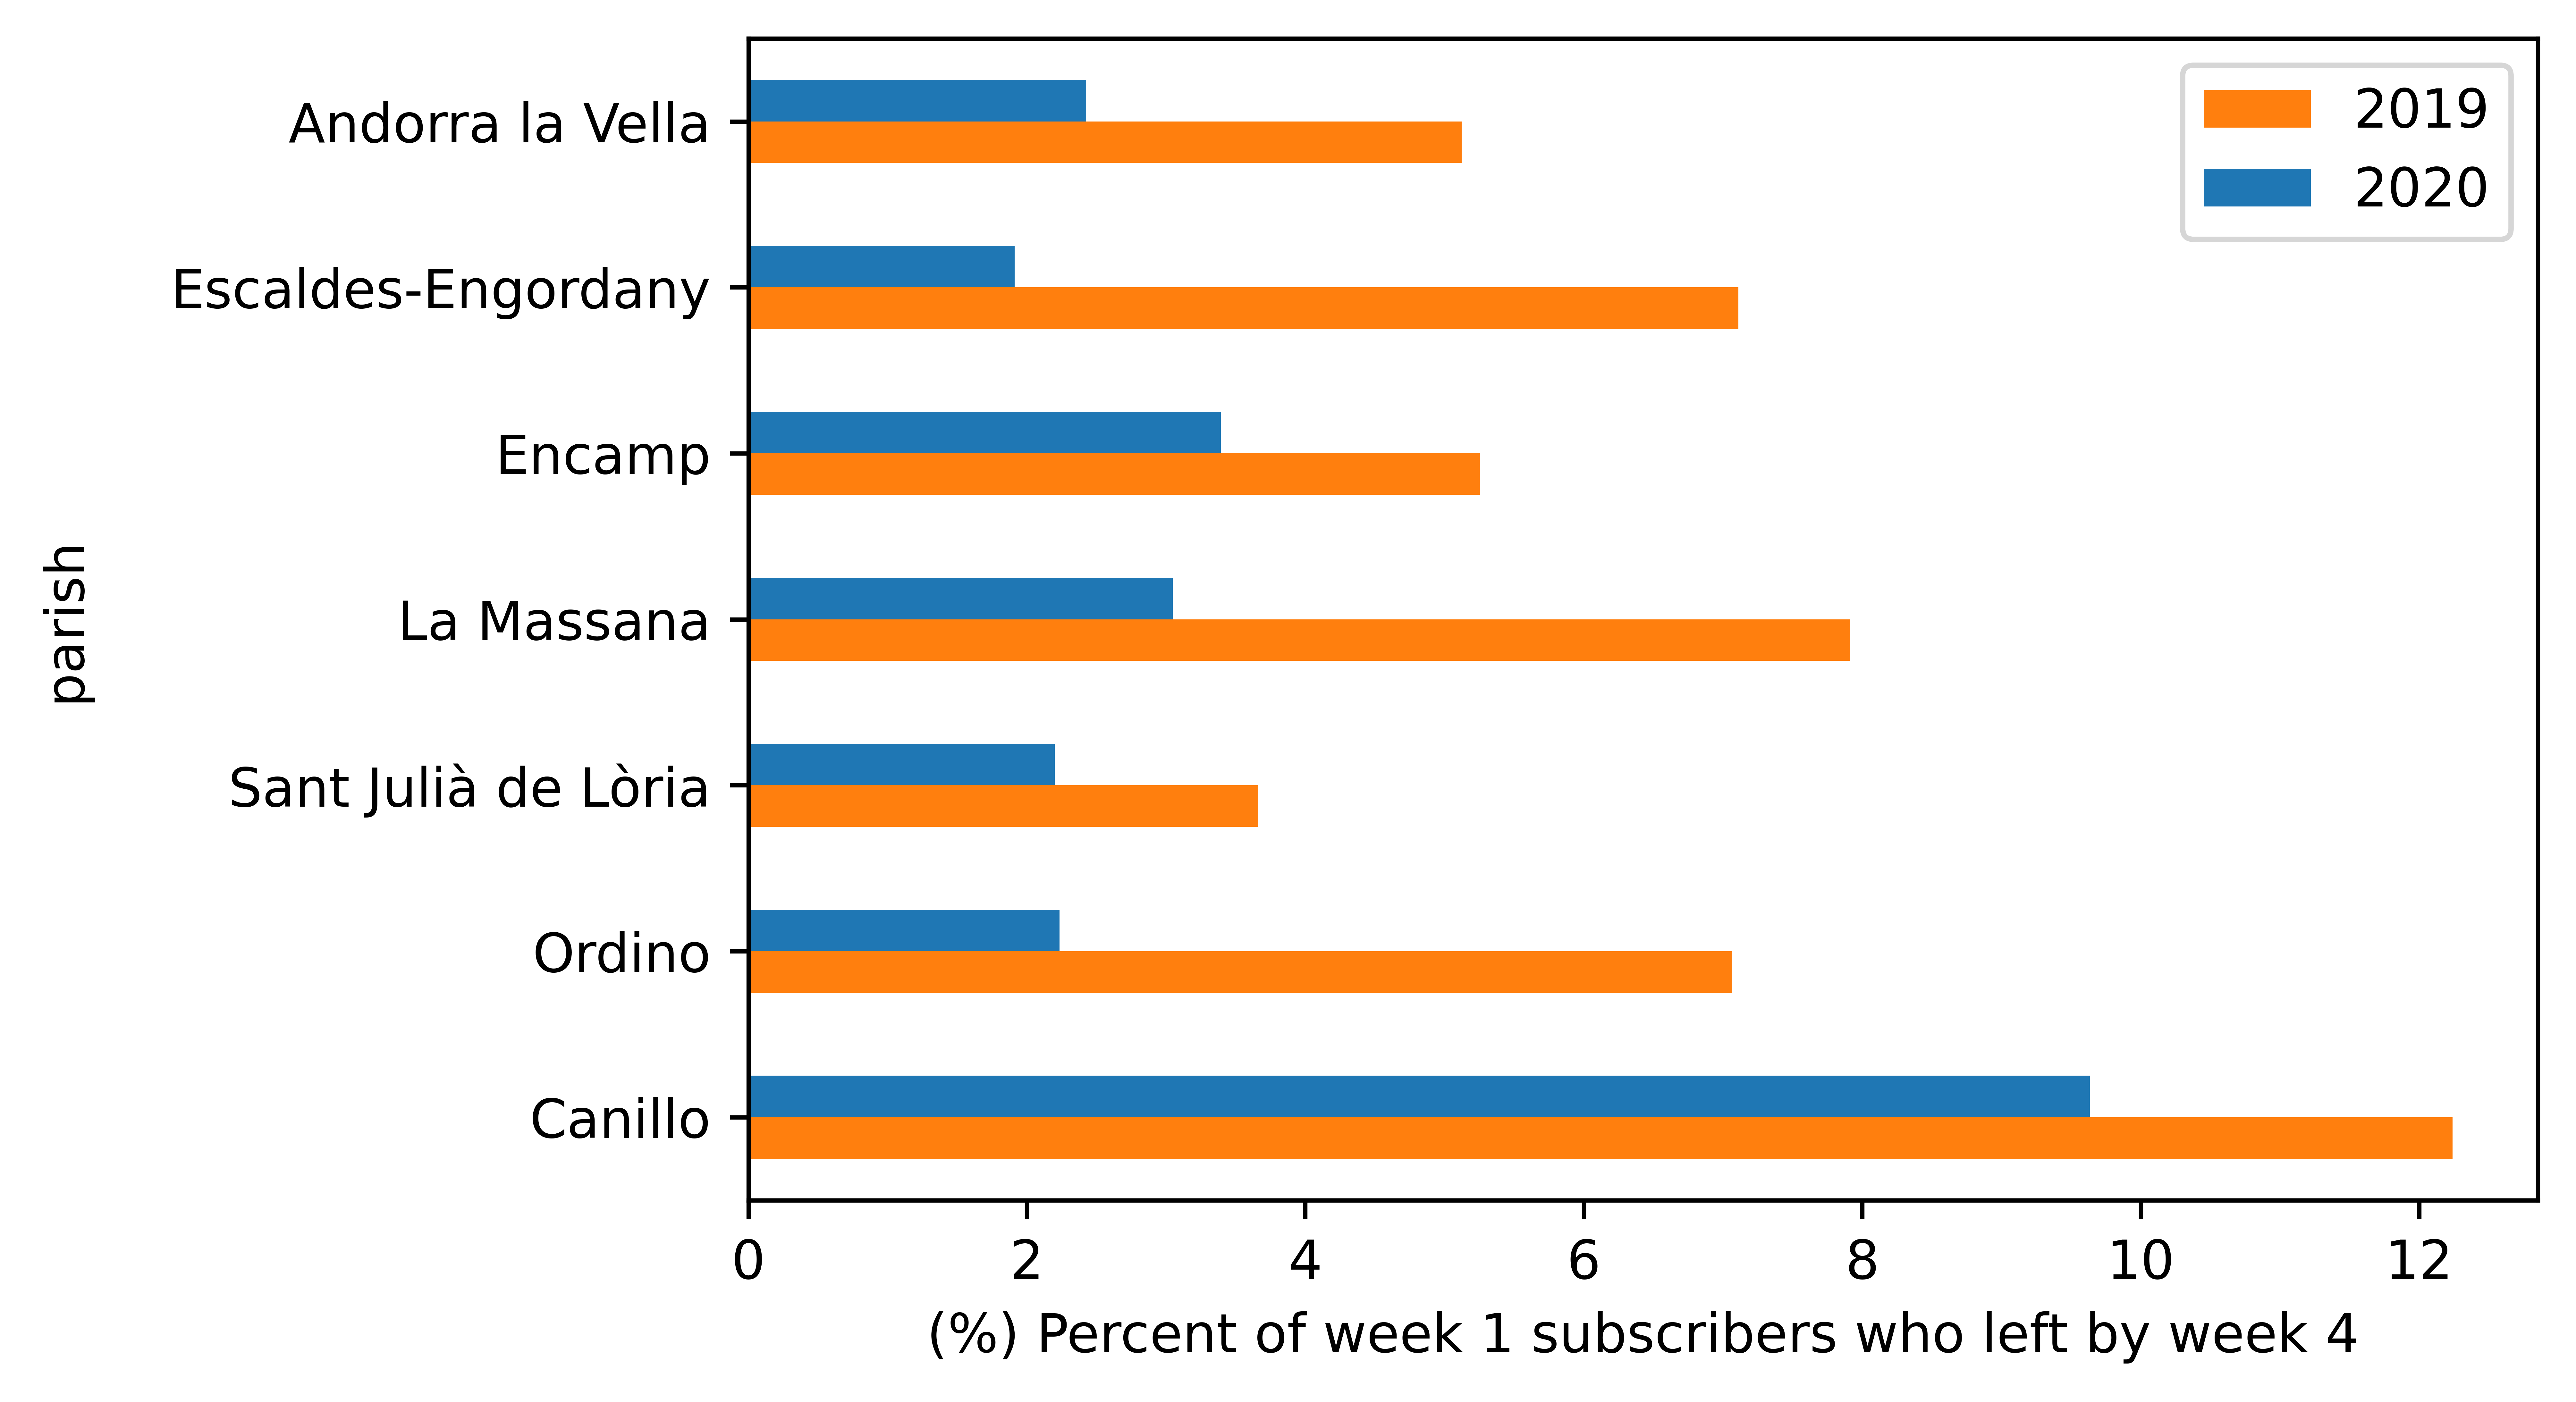

In [245]:
title_7days=title+'\n(restricted to users with at least 7 days of data)'
title_4nights=title+'\n(restricted to users with at least 4 nights of data)'
ax, decline_7days_df = plot_portion_decline(
    may_2019_7days_counts_df, 
    may_2020_7days_counts_df,
    #title_7days
)

ax, decline_4nights_df = plot_portion_decline(
    may_2019_4nights_counts_df,
    may_2020_4nights_counts_df,
    #title_4nights
)

In [246]:
# correlation between decline in subscribers vs no-shows to tests: 2020
(r, p_val) = pearsonr(
    decline_df['2020'].sort_index(), 
    parish_counts_df[P_DID_TEST_1_NOT_2].sort_index()
)
print('Pearson correlation between the portion of May 2020 mobile subscribers '\
      'present in week 1 who left by week 4 vs portion of people who did test 1 '\
      'but not test 2')
print('r=%0.4f (p=%0.4f)' % (r, p_val))

Pearson correlation between the portion of May 2020 mobile subscribers present in week 1 who left by week 4 vs portion of people who did test 1 but not test 2
r=0.9673 (p=0.0004)


Compare to decline in subscribers present in weeks 1-4 May *2019*

In [247]:
# correlation between decline in subscribers vs no-shows to tests: 2020
(r, p_val) = pearsonr(
    decline_df['2019'].sort_index(), 
    parish_counts_df[P_DID_TEST_1_NOT_2].sort_index()
)
print('Pearson correlation between the portion of May 2019 mobile subscribers '\
      'present in week 1 who left by week 4 vs portion of people who did test 1 '\
      'but not test 2')
print('r=%0.4f (p=%0.4f)' % (r, p_val))

Pearson correlation between the portion of May 2019 mobile subscribers present in week 1 who left by week 4 vs portion of people who did test 1 but not test 2
r=0.4959 (p=0.2577)


If the decline in subscribers was unrelated to people not showing up for their second test, then we would expect these values to be similar.

Robustness check: check correlation for subscriber data restricted to subscribers with a least 
- 7 days of data
- 4 nights of data

In [248]:
# Robustness check: Make the same comparisons for subscriber data restricted to 
# subscribers with a least 7 days of data
print('Restricting data to subscribers with at least 7 days of data:')
(r, p_val) = pearsonr(
    decline_7days_df['2020'].sort_index(), 
    parish_counts_df[P_DID_TEST_1_NOT_2].sort_index()
)
print('Pearson correlation between the portion of May 2020 mobile subscribers '\
      'present in week 1 who left by week 4 vs portion of people who did test 1 '\
      'but not test 2')
print('r=%0.4f (p=%0.4f)' % (r, p_val))

Restricting data to subscribers with at least 7 days of data:
Pearson correlation between the portion of May 2020 mobile subscribers present in week 1 who left by week 4 vs portion of people who did test 1 but not test 2
r=0.9545 (p=0.0008)


In [249]:
# Robustness check: Make the same comparisons for subscriber data restricted to 
# subscribers with a least 4 nights of data
print('Restricting data to subscribers with at least 4 nights of data:')
(r, p_val) = pearsonr(
    decline_4nights_df['2020'].sort_index(), 
    parish_counts_df[P_DID_TEST_1_NOT_2].sort_index()
)
print('Pearson correlation between the portion of May 2020 mobile subscribers '\
      'present in week 1 who left by week 4 vs portion of people who did test 1 '\
      'but not test 2')
print('r=%0.4f (p=%0.4f)' % (r, p_val))

Restricting data to subscribers with at least 4 nights of data:
Pearson correlation between the portion of May 2020 mobile subscribers present in week 1 who left by week 4 vs portion of people who did test 1 but not test 2
r=0.9672 (p=0.0004)


#### Plot it

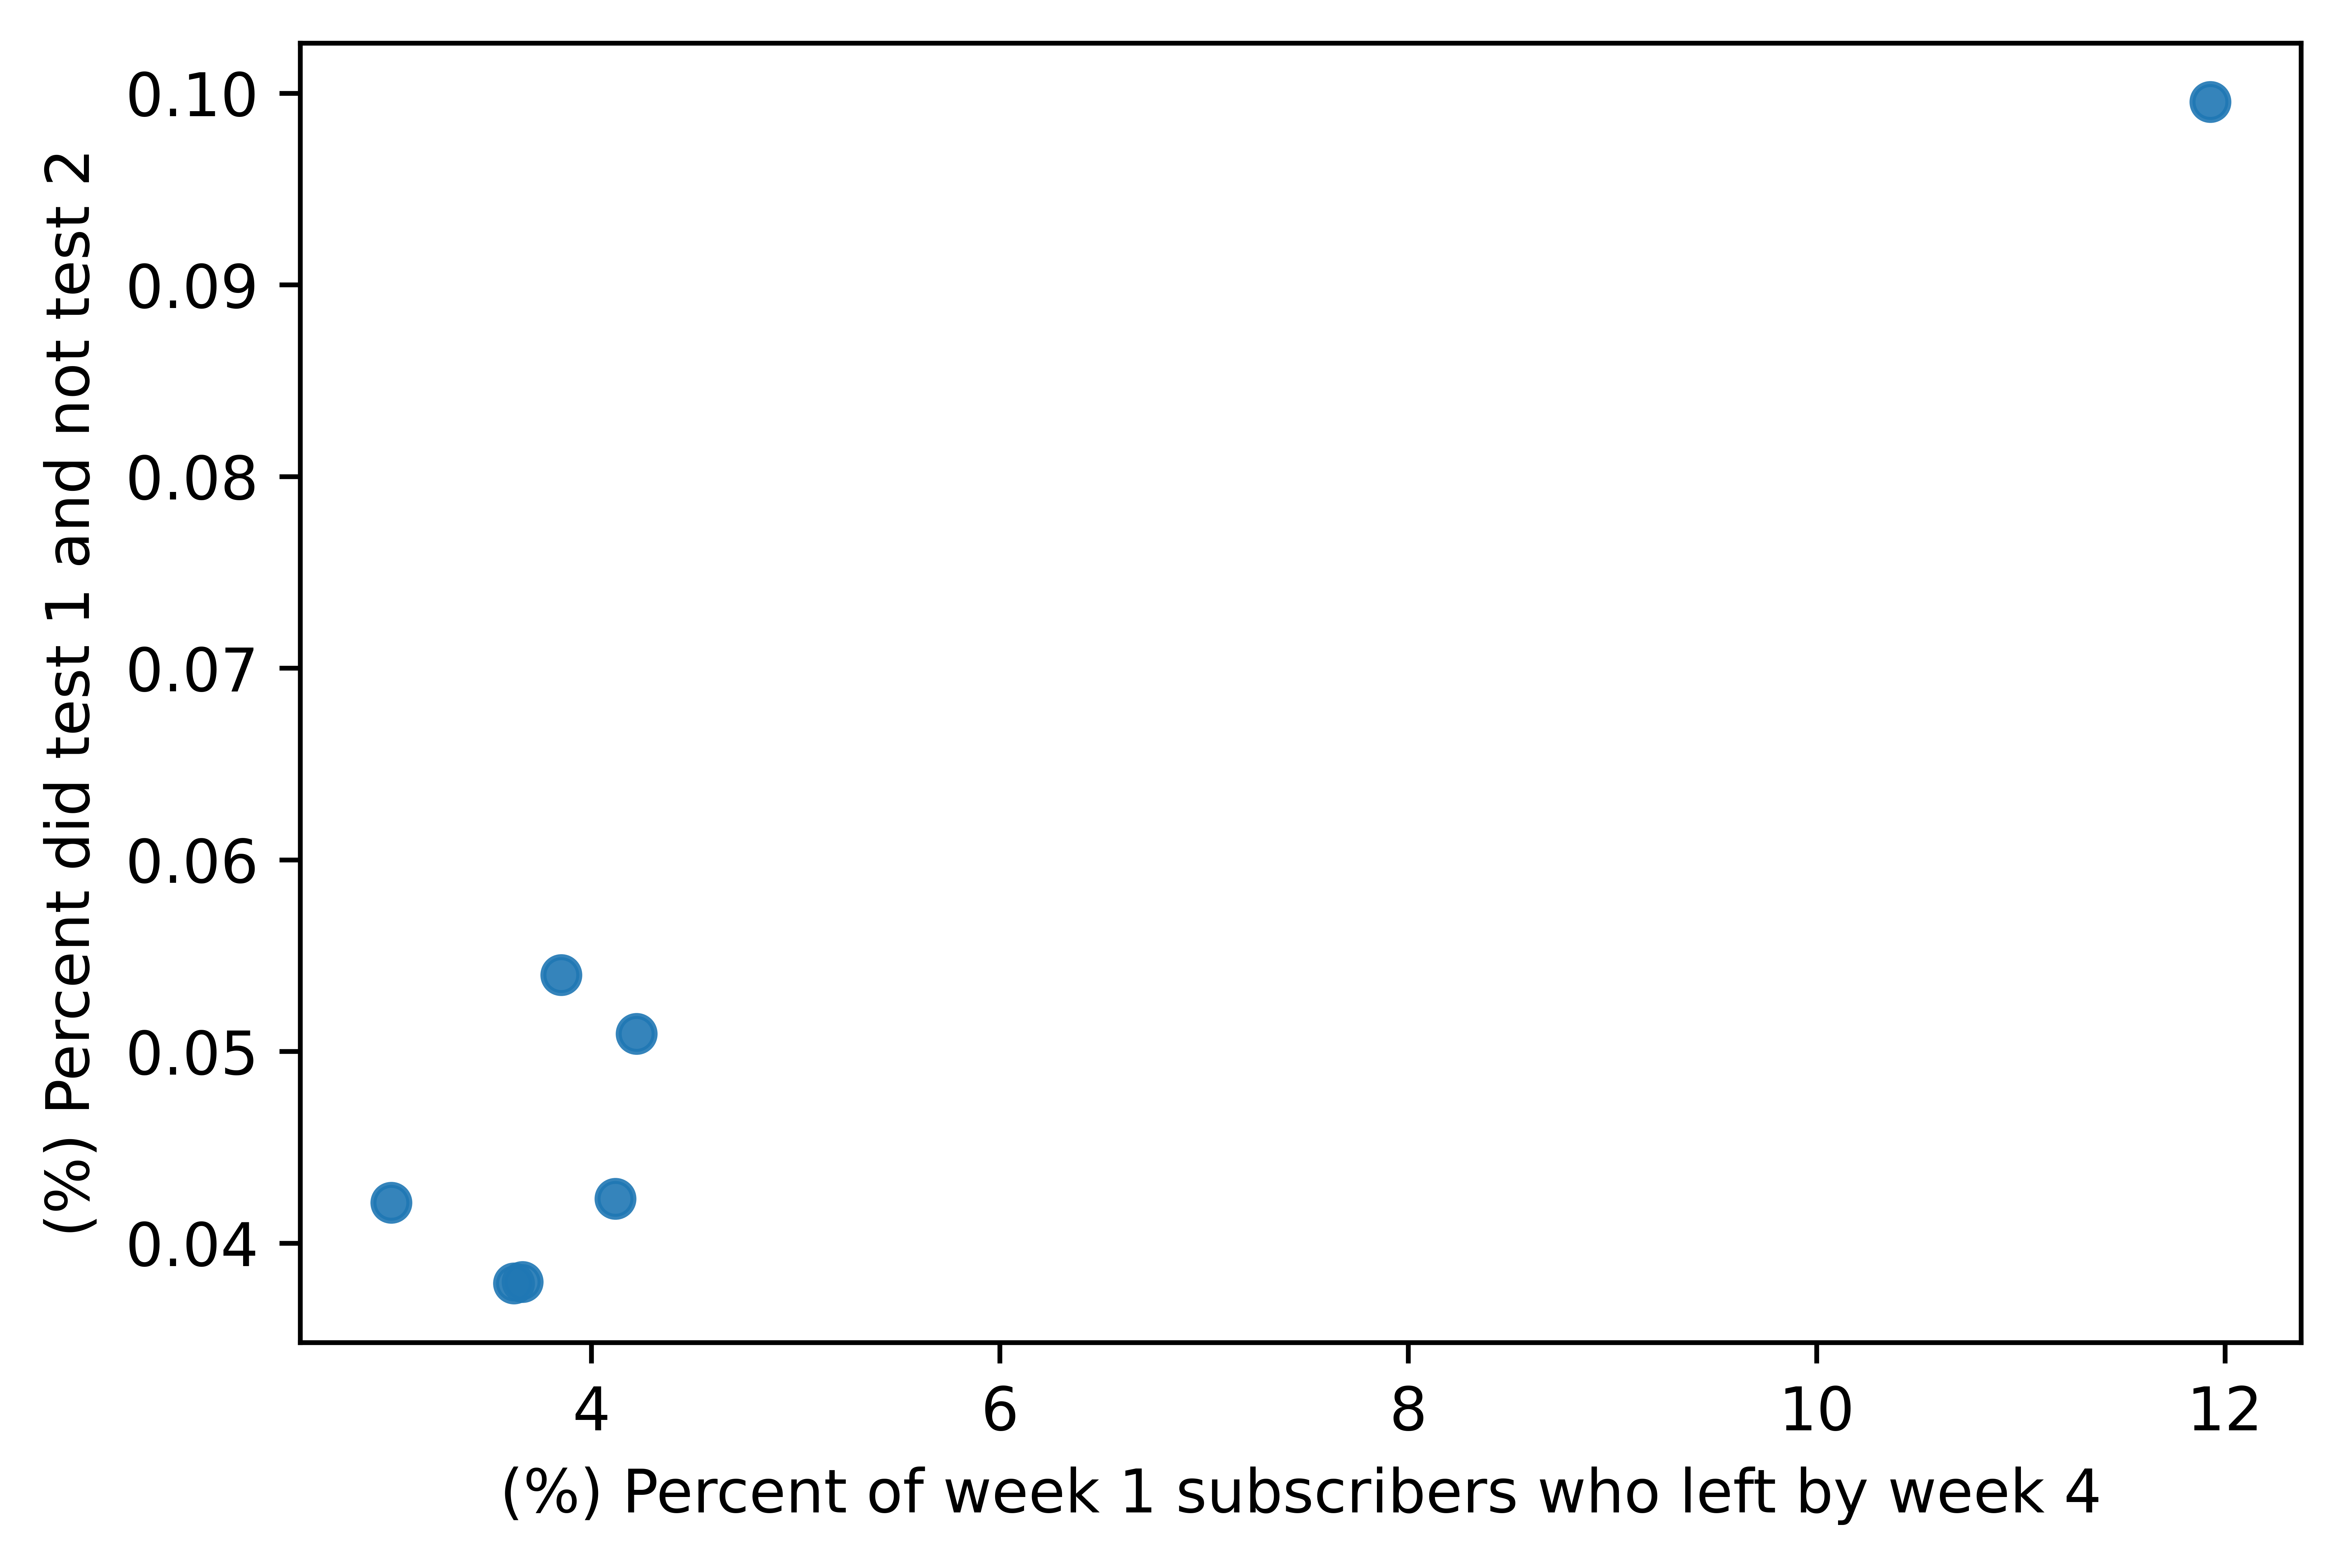

In [253]:
fig, ax = plt.subplots(dpi=600)
x_2020 = decline_df['2020'].sort_index()
y_2020 = parish_counts_df[P_DID_TEST_1_NOT_2].sort_index()
for i, (x,y) in enumerate(zip(x_2020, y_2020)):
    ax.scatter(x, y, color=color_2020, alpha=0.9, label='2020' if i == 0 else '')
ax.set_xlabel('(%) Percent of week 1 subscribers who left by week 4')
ax.set_ylabel('(%) Percent did test 1 and not test 2')
title = 'Change in May population and test participation'
# _ = ax.set_title(title)

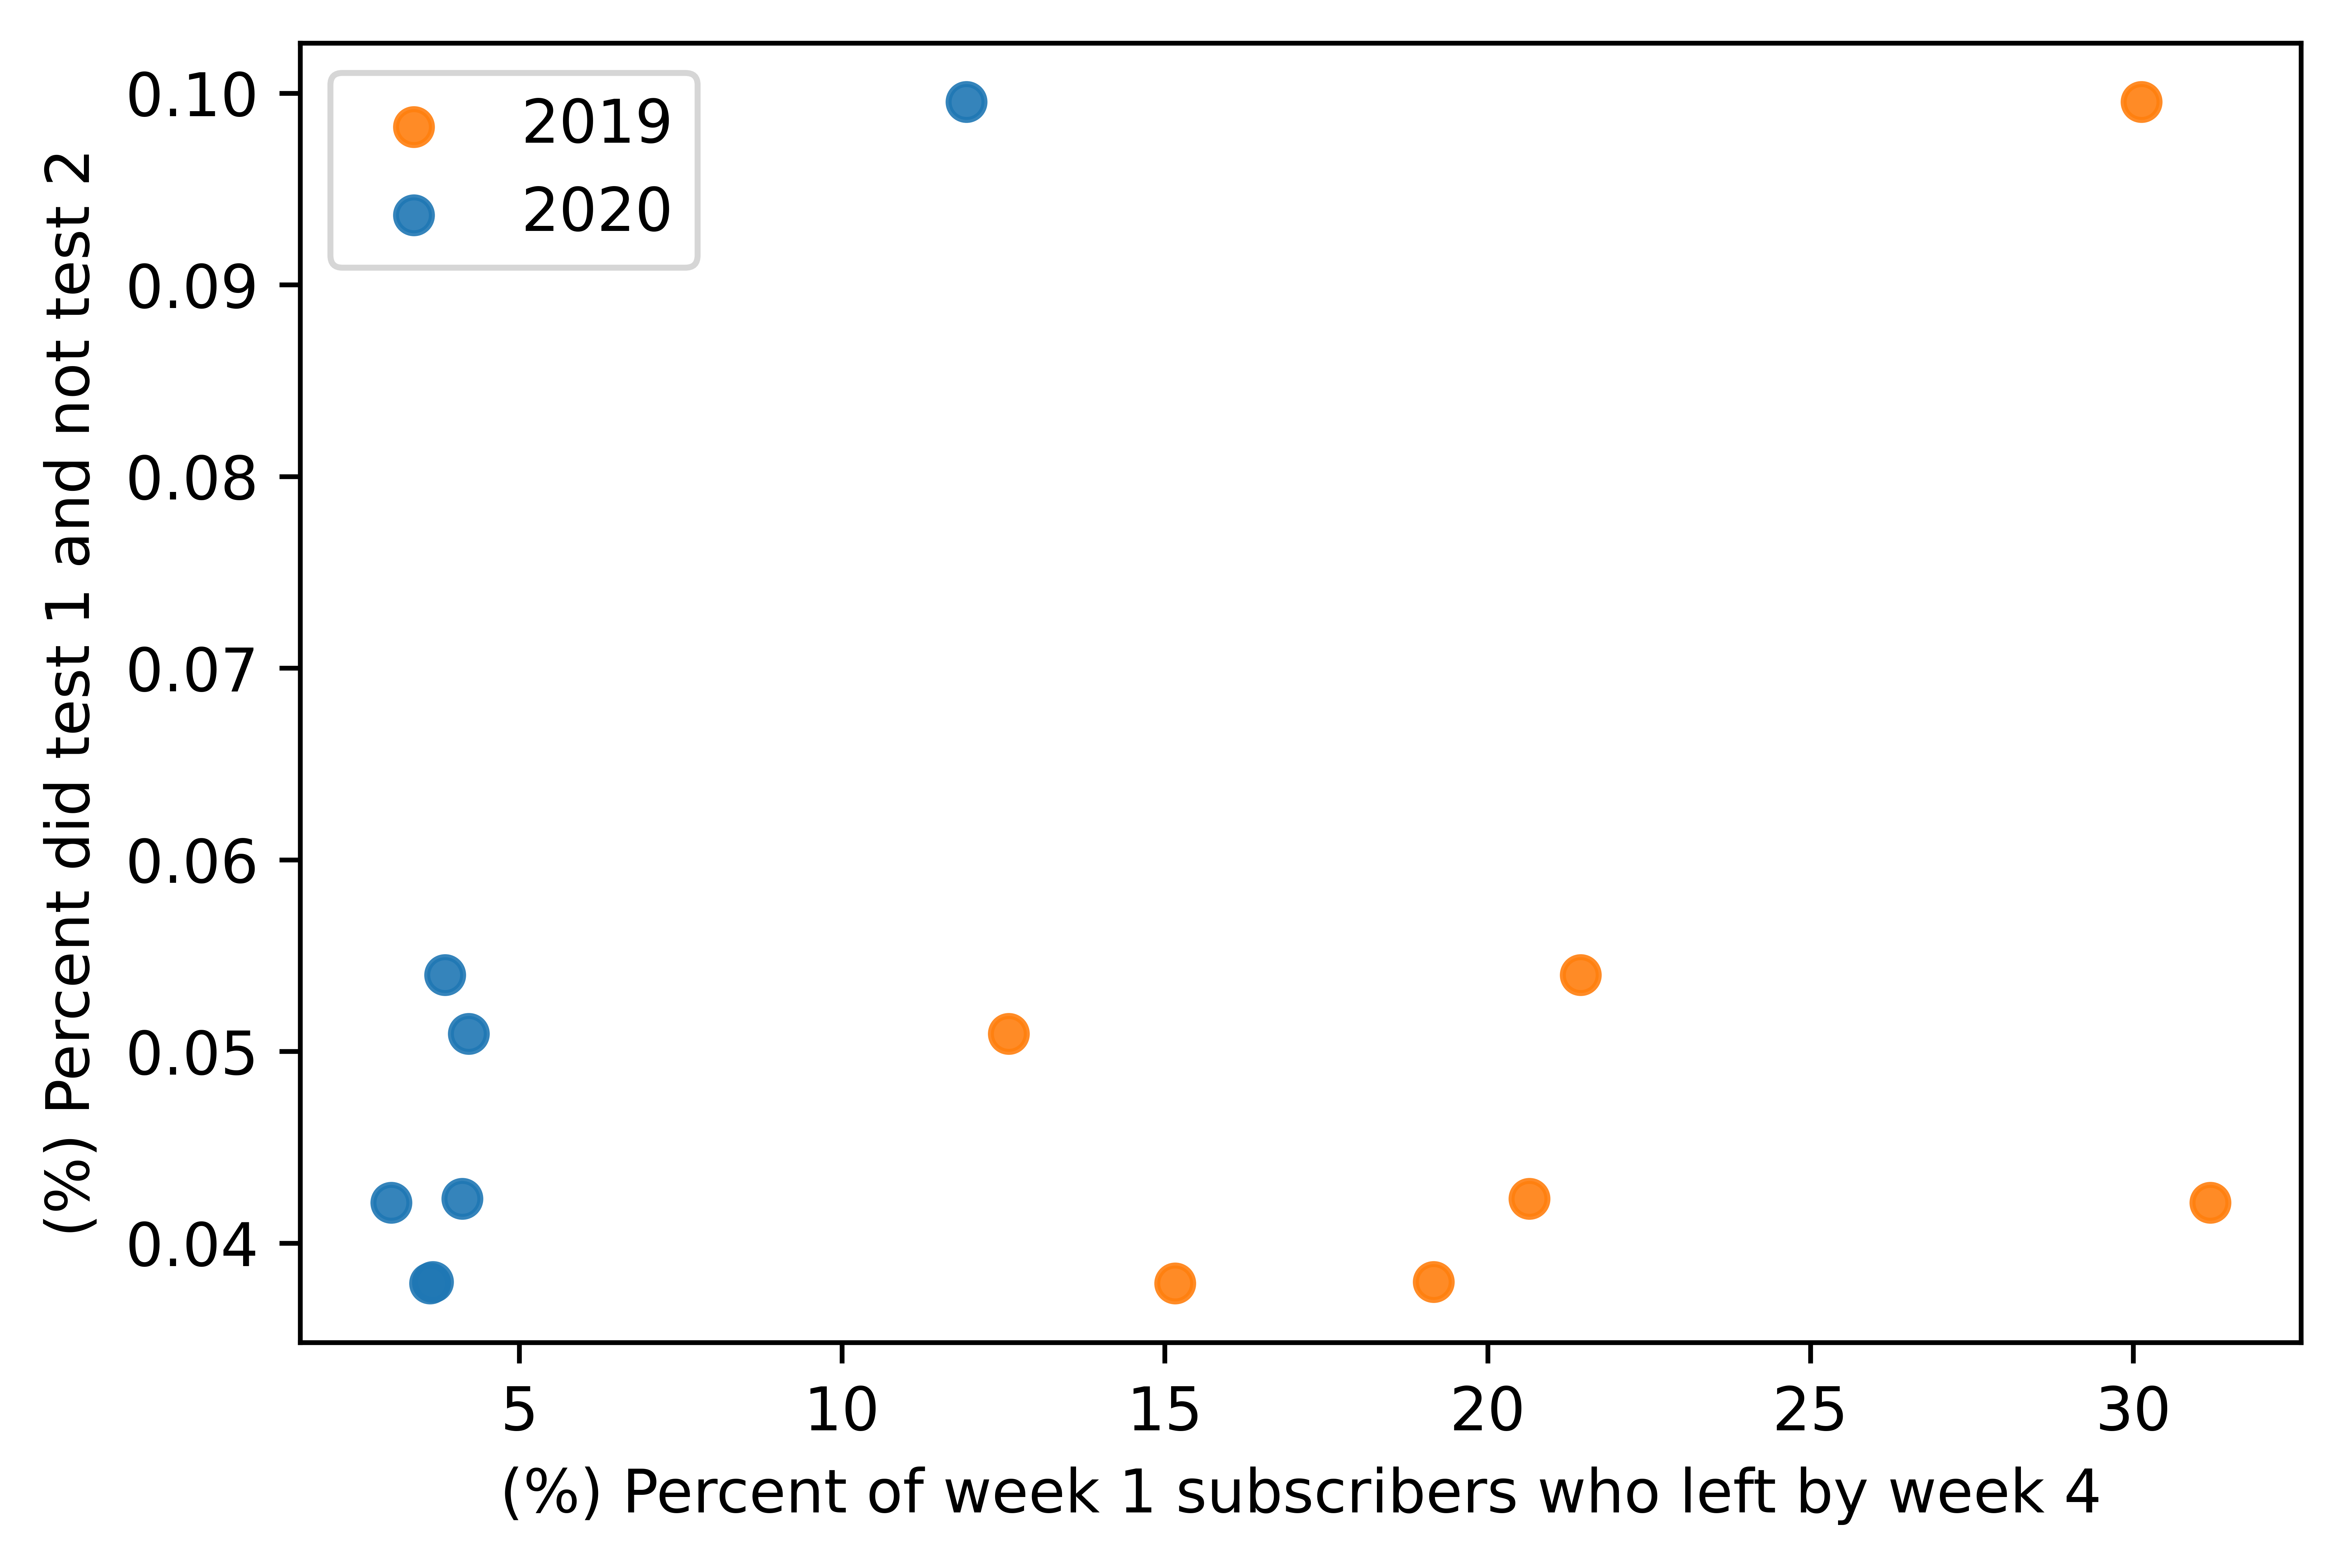

In [252]:
fig, ax = plt.subplots(dpi=600)
for i, (x,y) in enumerate(zip(decline_df['2019'].sort_index(), parish_counts_df[P_DID_TEST_1_NOT_2].sort_index())):
    ax.scatter(x, y, color=color_2019, alpha=0.9, label='2019' if i == 0 else '')
x_2020 = decline_df['2020'].sort_index()
y_2020 = parish_counts_df[P_DID_TEST_1_NOT_2].sort_index()
for i, (x,y) in enumerate(zip(x_2020, y_2020)):
    ax.scatter(x, y, color=color_2020, alpha=0.9, label='2020' if i == 0 else '')
ax.set_xlabel('(%) Percent of week 1 subscribers who left by week 4')
ax.set_ylabel('(%) Percent did test 1 and not test 2')
title = 'Change in May population and test participation'
# ax.set_title(title)
_ = ax.legend()

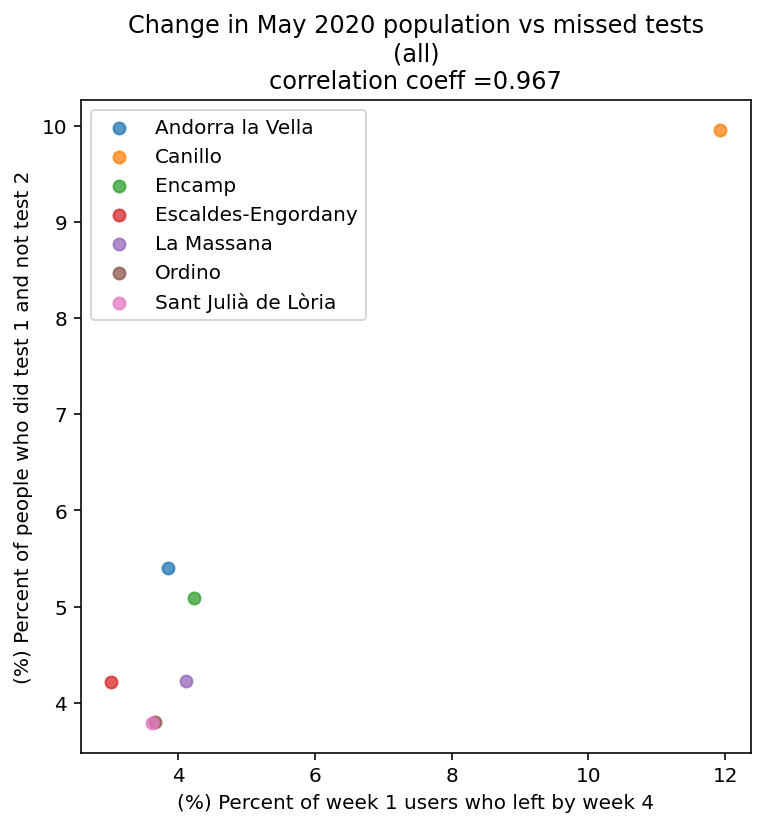

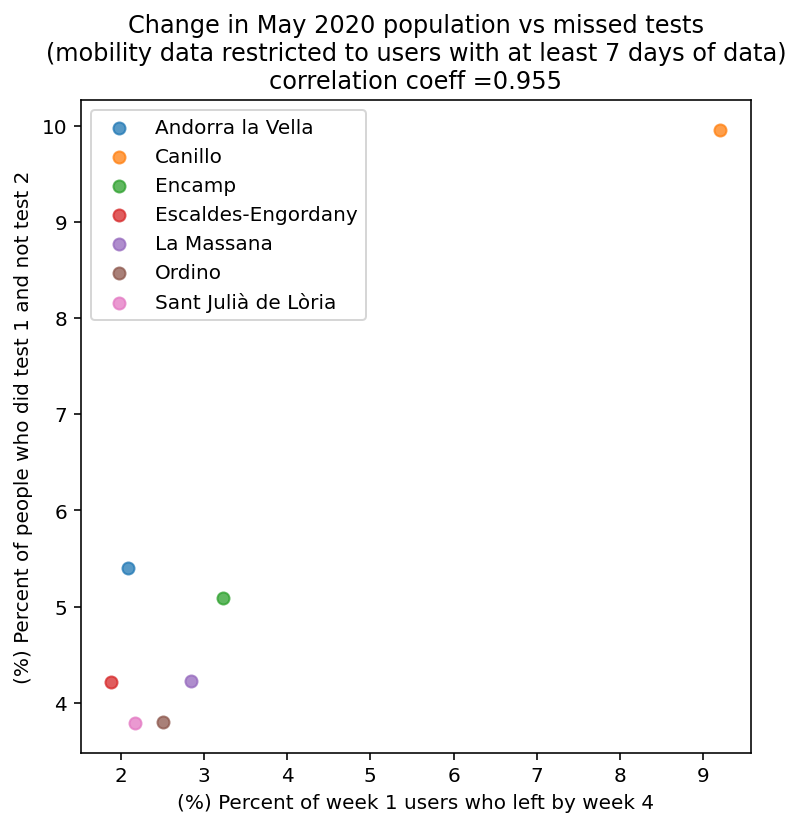

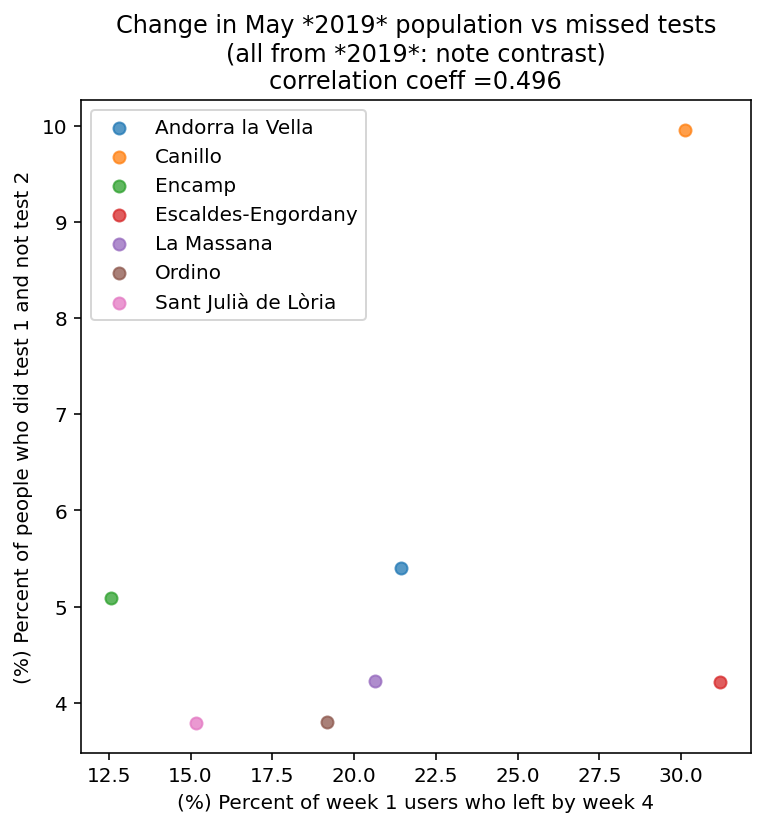

In [163]:
def plot_departures_vs_noshows(presence, tests, title):
    x=presence.sort_index()*100
    y=tests.sort_index()*100
    corr = np.corrcoef(x,y)[0,1].round(3)
    index=x.index
    fig, ax = plt.subplots(figsize=(6,6))
    for i, (x,y) in enumerate(zip(x,y)):
        ax.scatter(x, y,label=index.values[i],alpha=0.75)
    ax.legend()
    ax.set_title(title+'\ncorrelation coeff =%s'%corr)
    ax.set_xlabel('(%) Percent of week 1 users who left by week 4')
    ax.set_ylabel('(%) Percent of people who did test 1 and not test 2')
    plt.show()
    return ax

plot_departures_vs_noshows(may_2020_counts_df[P_DECLINE],
                           parish_counts_df[P_DID_TEST_1_NOT_2],
                          'Change in May 2020 population vs missed tests\n(all)')
    
plot_departures_vs_noshows(may_2020_7days_counts_df[P_DECLINE],
                           parish_counts_df[P_DID_TEST_1_NOT_2],
                          'Change in May 2020 population vs missed tests\n(mobility data restricted to users with at least 7 days of data)')
    
    
ax = plot_departures_vs_noshows(may_2019_counts_df[P_DECLINE],
                               parish_counts_df[P_DID_TEST_1_NOT_2],
                              'Change in May *2019* population vs missed tests\n(all from *2019*: note contrast)')
    